Income and Lifespan
============== 

**This Project examines if there are correlation between Income (before taxes) and the average lifespan. We will look at the correlation on a municipality level.
We will start out by importing the relevant packages, and then reading data from dst.dk. 
Then the data will be cleaned, and the two data frames will be merged.
Furthermore, we take a look at the data by creating tables as well as some interactive plots.
Lastly, we investigate the correlation between income and average lifespan, and present our conclusion.**

Imports and set magics:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2 # install with pip install matplotlib-venn
import pydst
import geopandas as gpd
import descartes

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject
dst = pydst.Dst(lang='en')

# Read and clean data

## Lifespan data

We will start out by loading the lifespan data from dst. 

In [2]:
dst.get_subjects()


,id,desc,active,hasSubjects
0,02,Population and elections,True,True
1,05,Living conditions,True,True
2,03,Education and knowledge,True,True
3,18,Culture and National Church,True,True
4,04,"Labour, income and wealth",True,True
5,06,Prices and consumption,True,True
6,14,National accounts and government finances,True,True
7,16,Money and credit market,True,True
8,13,External economy,True,True
9,07,Business sector in general,True,True


Above are the different subjects on dst.dk. After looking at the web page we found that the table id for the data we want, is "LIV01". This will be used to load the data.

In [34]:
LIVO1_vars = dst.get_variables(table_id='LIVO1') #getting variables in the data
print(LIVO1_vars) #observing the variable names in the data

#Loading data
LIVO1 = dst.get_data(table_id = 'LIVO1', variables={'OMRÅDE':['*'], 'TID':['*'],'AKTP':['O1'] }) 
LIVO1.sort_values(by=['OMRÅDE', 'TID'], ascending=False)
print(LIVO1)



       id         text  elimination   time  \
0    AKTP  key figures        False  False   
1  OMRÅDE       region         True  False   
2     Tid         time        False   True   

                                              values                      map  
0  [{'id': 'O1', 'text': 'Life expectancy (years)...                      NaN  
1  [{'id': '000', 'text': 'All Denmark'}, {'id': ...  denmark_municipality_07  
2  [{'id': '2008', 'text': '2008'}, {'id': '2009'...                      NaN  
                  OMRÅDE   TID                     AKTP INDHOLD
0            All Denmark  2008  Life expectancy (years)    78.5
1     Region Nordjylland  2008  Life expectancy (years)    78.5
2     Region Midtjylland  2008  Life expectancy (years)    79.0
3      Region Syddanmark  2008  Life expectancy (years)    78.8
4     Region Hovedstaden  2008  Life expectancy (years)    78.2
...                  ...   ...                      ...     ...
1139              Rebild  2018  Life expectancy

Next we want to translate the variables to english and remove all non-municipality observations. 
We also drop the variable "AKTP", since we will not need it for the analysis.

In [36]:
lvt_en=LIVO1.rename(columns={"OMRÅDE": "municipality", "TID": "YEAR", "INDHOLD": "AVERAGE LIFESPAN", })#renaming
lvt_en = dataproject.only_keep_municipalities(lvt_en) #keeping only municipal observations

lvt_en.drop(["AKTP"], axis=1, inplace=True)

print(lvt_en)

       municipality  YEAR AVERAGE LIFESPAN
6        Copenhagen  2008             75.6
7     Frederiksberg  2008             78.0
8          Ballerup  2008             77.6
9           Brøndby  2008             77.4
10           Dragør  2008             80.3
...             ...   ...              ...
1139         Rebild  2018             80.8
1140  Mariagerfjord  2018             80.4
1141     Jammerbugt  2018             80.8
1142        Aalborg  2018             80.6
1143       Hjørring  2018             81.1

[1078 rows x 3 columns]


## Income data

We now shift our focus towards the Income data. 

Before we load it, we need to look at the id for som of the variables.
We can then use this id to load the correct data.

In [42]:
#Looking at the id for the variables in the data
indk_vars = dst.get_variables(table_id='INDKP101')
for id in ['ENHED','INDKOMSTTYPE','Tid']:
    print(id)
    values = indk_vars.loc[indk_vars.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')
        
INDKP101_vars = dst.get_variables(table_id='INDKP101')
print(INDKP101_vars)

#id 105 was pretax income, and id 116 was average income for all people. We choose them:
INDKP101 = dst.get_data(table_id = 'INDKP101', variables={'OMRÅDE':['*'],'INDKOMSTTYPE':['105'],'Tid':['*'],'ENHED':['116']})
print(INDKP101.head())


ENHED
 id = 101, text = People with type of income (number)
 id = 110, text = Amount of income (DKK 1.000)
 id = 116, text = Average income for all people (DKK)
 id = 121, text = Average income for people with type of income (DKK)
INDKOMSTTYPE
 id = 100, text = 1 Disposable income (2+30-31-32-35)
 id = 105, text = 2 Pre-tax Income, total (3+7+22+26+29)
 id = 110, text = 3 Primary income (4+5+6)
 id = 115, text = 4 Wages and salaries etc., total
 id = 120, text = 5 Entrepreneurial income, total
 id = 125, text = 6 Received fees subject to labour market contributions
 id = 130, text = 7 Public transfer incomes(8+14+19)
 id = 135, text = 8 Unemployment and cash benefits (9+10+11+12+13)
 id = 140, text = 9 Unemployment benefits
 id = 145, text = 10 Other benefits from unemployment funds
 id = 150, text = 11 Cash benefits
 id = 155, text = 12 Job training & Limited employment benefits
 id = 160, text = 13 Sickness- & parental leave
 id = 165, text = 14 Other transfers(15+16+17+18)
 id = 170

Again, we want to translate the variables to english, and exclude non-municipal observations.

We also drop variables that are not relevant.

In [44]:
inc_en=INDKP101.rename(columns={"OMRÅDE": "municipality", "TID": "YEAR", "INDHOLD": "INCOME","INDKOMSTTYPE":"TYPE OF INCOME","KOEN":"SEX" })
inc_en = dataproject.only_keep_municipalities(inc_en)
inc_en = inc_en.loc[inc_en["YEAR"]>=2008]
inc_en.drop(["ENHED", "SEX","TYPE OF INCOME"], axis=1, inplace=True)
print(inc_en)

         municipality  YEAR  INCOME
0              Assens  2012  267784
1     Faaborg-Midtfyn  2012  264002
2          Kerteminde  2012  269904
3              Nyborg  2012  267072
4              Odense  2012  260813
...               ...   ...     ...
3515            Morsø  2017  277524
3516          Thisted  2017  289210
3517      Brønderslev  2017  292397
3518    Frederikshavn  2017  290973
3519  Vesthimmerlands  2017  284471

[1078 rows x 3 columns]


 # Merge data sets


We have now created two data frames with municipality and year in both of them. We can then merge the data frames in order to get a single data frame.

In [46]:
data = pd.merge(lvt_en, inc_en, on=['YEAR', 'municipality'], how='left')
print(data)

       municipality  YEAR AVERAGE LIFESPAN  INCOME
0        Copenhagen  2008             75.6  263569
1     Frederiksberg  2008             78.0  308755
2          Ballerup  2008             77.6  279522
3           Brøndby  2008             77.4  257466
4            Dragør  2008             80.3  332548
...             ...   ...              ...     ...
1073         Rebild  2018             80.8  332089
1074  Mariagerfjord  2018             80.4  299693
1075     Jammerbugt  2018             80.8  293060
1076        Aalborg  2018             80.6  302998
1077       Hjørring  2018             81.1  298657

[1078 rows x 4 columns]


Before we move on to take a look at the data, we need to transform the variable AVERAGE LIFESPAN into a numerical variable.

In [48]:
data['AVERAGE LIFESPAN'] = pd.to_numeric(data['AVERAGE LIFESPAN'],errors='coerce')

# Explore the data

Before visualizing the data we want to clean it a bit. Let's find out if there are any missing values.

In [49]:
missing_values = data[data.isnull().any(axis=1)]
print(missing_values['municipality'].unique())



['Ærø' 'Fanø' 'Samsø' 'Læsø']


It turns out that for these 4 municipalities there are some missing values, and therefor we will remove them from the analysis.

Ærø, Fanø, Samsø and Læse are all municipalities with very few citizens, so removing them will not be significant for the outcome of the analysis.

In [50]:
data = data[data["municipality"]!= "Samsø"]
data = data[data["municipality"]!= "Læsø"]
data = data[data["municipality"]!= "Fanø"]
data = data[data["municipality"]!= "Ærø"]



We are now ready to visualize the data. First we will create a function that can plot the data for a given municipality.

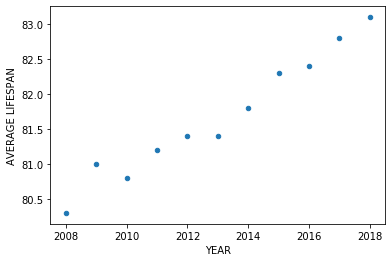

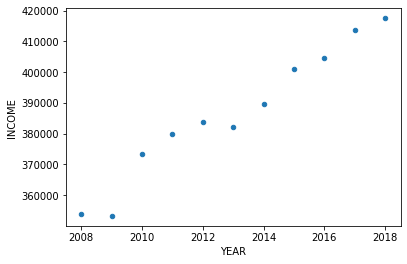

In [13]:

def plot_empl_inc(data,dataset,municipality): 
    
    if dataset == 'Average Lifespan':
        y = 'AVERAGE LIFESPAN'
    else:
        y = 'INCOME'
    
    data.loc[data["municipality"]==municipality].plot.scatter(x='YEAR',y=y,style='-o')
    
plot_empl_inc(data,"Average Lifespan","Allerød")

plot_empl_inc(data,"INCOME","Allerød")


Here we have taken Allerød as an example. It is shown that both the average lifespan and income is increasing from 2008 to 2018.

We can also do this interactively by using the widgets package.

In [51]:

widgets.interact(plot_empl_inc, 
    
    data = widgets.fixed(data),
    dataset = widgets.Dropdown(description='Dataset', 
                              options=['Average Lifespan','Income']),
    municipality = widgets.Dropdown(description='Municipality', 
                                    options=data.municipality.unique())
                 
); 

interactive(children=(Dropdown(description='Dataset', options=('Average Lifespan', 'Income'), value='Average L…

By scrolling through the different municipalities it turns out that almost all of them have increasing lifespan and income in this period.
In 2009 and 2010 income was lower as a result of the economic crisis. In the following years, incomes started to rise again, which is generally as expected in a country with consistent growth. Life expentancy fell in 2010, which may be attributed in part to the economic crisis, as it generally correlated well with income. However, since the economic crisis didn't cut back on public health care, it is unlikely to have caused such a large fluctuation in life expectancy by itself. 

# Analysis

We can now have deeper look into the correlation between Income and Average Lifespan.

In order to visualize if the municipalities with high income also have a high average lifespan, we will create a municipality map of Denmark with colours indicating the values. We will use numbers from 2008 and 2018

In [56]:
#reading shp file with map data
map_df = gpd.read_file("KOM_MULTIPART.shp")
merged_munis = data.municipality.unique() #finding unique municipalities in our data
map_munis = map_df.KOMNAVN.unique() #finding unique municipalities in the map data

# List of municipalities in merged_munis that are named different our map data and the opposite

#finding the difference 
diff1 = [muni for muni in merged_munis if muni not in map_munis] 
diff2 = [muni for muni in map_munis if muni not in merged_munis] 

print(f'Municipalities in our API data but named differently in the map data: {diff1}')
print(f'Municipalities in our map data but named differently in API data: {diff2}')

Municipalities in our API data but named differently in the map data: ['Copenhagen', 'Høje-Taastrup']
Municipalities in our map data but named differently in API data: ['København', 'Læsø', 'Samsø', 'Ærø', 'Fanø', 'Christiansø', 'Høje Taastrup']


We can see that we need to rename som municipalities.

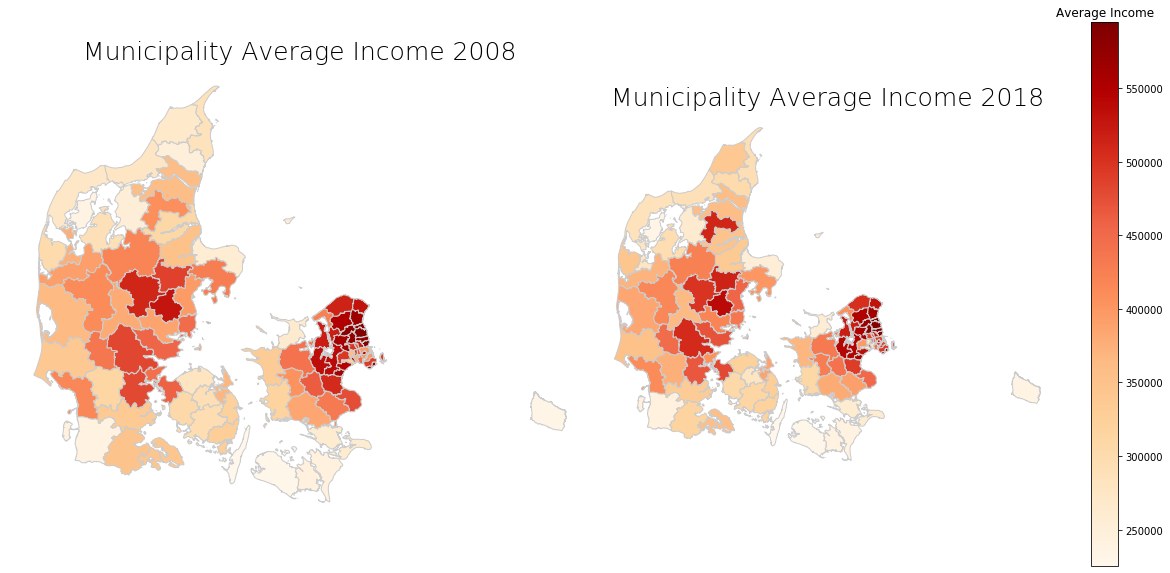

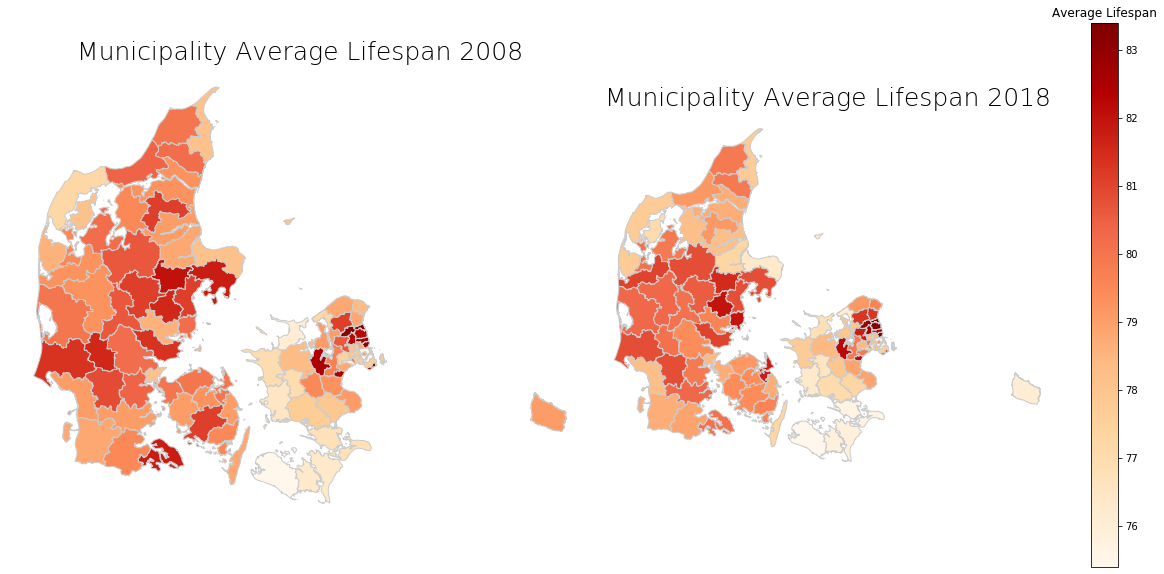

In [59]:
data2 = data.copy()

# Changing municipality names so the files can merge
data2.loc[data2.municipality=='Copenhagen', 'municipality'] = 'København'
data2.loc[data2.municipality=='Høje-Taastrup', 'municipality'] = 'Høje Taastrup'

#changing types on the variables
data2["AVERAGE LIFESPAN"] = data2["AVERAGE LIFESPAN"].astype(str)
data2["INCOME"] = data2["INCOME"].astype(str)


#creating data from 2008 and 2018
data2_08 = data2[data2["YEAR"]==2008]
data2_18 = data2[data2["YEAR"]==2018]

#merging the two data sets on municipality
merged_map = pd.merge(data2_18, data2_08, how='left', left_on='municipality', right_on='municipality')

#removing columns so we only keep municipality, lifespan and income columns 
merged_map2 = merged_map[['municipality','AVERAGE LIFESPAN_x', 'AVERAGE LIFESPAN_y', 'INCOME_x', 'INCOME_y']]

#merging the map data with the dst data
final_map = pd.merge(map_df, merged_map2, how='left', left_on='KOMNAVN', right_on='municipality')

#Dropping missing values 
final_map = final_map.dropna()





## The variables to be visualized
VisVarinc08 = 'INCOME_y'
VisVarinc18 = 'INCOME_x'
VisVarlvt08 = 'AVERAGE LIFESPAN_y'
VisVarlvt18 = 'AVERAGE LIFESPAN_x'



# set the colour range in the plot
vminUNE, vmaxUNE = merged_map['AVERAGE LIFESPAN_y'].min() , merged_map['AVERAGE LIFESPAN_x'].max()
vminFer, vmaxFer = merged_map['INCOME_y'].min() , merged_map['INCOME_x'].max()

######################################## Average Income ##########################################

# create figure, axes, size, remove whitespace and align the size of the figures in Matplotlib
side_length = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(side_length * 2.1, side_length) , subplot_kw={'aspect': 1})
fig.subplots_adjust(hspace=0.0, wspace=0.0)

# removing axis from our map
ax1.axis('off')
ax2.axis('off')

# add title and size of title
ax1.set_title('Municipality Average Income 2008', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

## create the actual plot
ax1=final_map.plot(column=VisVarinc08,  cmap='OrRd', ax=ax1, edgecolor='0.8')

# Attempt to get two maps of equal size
ax1.set_aspect('equal')

# title for second map
ax2.set_title('Municipality Average Income 2018', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create the actual plot
ax2=final_map.plot(column=VisVarinc18,  cmap='OrRd', ax=ax2, edgecolor='0.8')

# Attempt to get two maps of equal size
ax2.set_aspect('equal')

## mapping the colour scale
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vminFer, vmax=vmaxFer))

# Empty array
sm._A = []

# create colour bar
cbar = fig.colorbar(sm)

# colour bar title
cbar.ax.set_title('Average Income')

#show plot
plt.show()


######################  Average LifeSpan ############################
# comments regarding the first plot also apply here

side_length = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(side_length * 2.1, side_length) , subplot_kw={'aspect': 1})
fig.subplots_adjust(hspace=0.0, wspace=0.0)


ax1.axis('off')
ax2.axis('off')

ax1.set_title('Municipality Average Lifespan 2008', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

ax1=final_map.plot(column=VisVarlvt08,  cmap='OrRd', ax=ax1, edgecolor='0.8')
ax1.set_aspect('equal')


ax2.set_title('Municipality Average Lifespan 2018', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

ax2=final_map.plot(column=VisVarlvt18,  cmap='OrRd', ax=ax2, edgecolor='0.8')

ax2.set_aspect('equal')

sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vminUNE, vmax=vmaxUNE))

sm._A = []

cbar = fig.colorbar(sm)

cbar.ax.set_title('Average Lifespan')

plt.show()


It is the case for both income and life expentancy that the right graph is more red than the left graph. This illustrates the positive trend that nearly all municipalities have met in the time period for both variables. It appears that the municipalities of high life expectancy and high income are largely concentrated around the same areas - not in the major cities, but around them. For example, the area north of Copenhagen and the area west of Aarhus are known as high income areas, and this shows in the graphs. Thus, the figures provide some evidence of a correlation between income and life expentancy.

Another way of analyzing the data is to simply look at the mean of income and average lifespan for each municipality.

We can then observe if the municipalities have the same position on the ranked list in the two categories.

In [116]:
#calculating mean of INCOME and AVERAGE LIFESPAN, for each municipality
data_statistics=data.groupby('municipality').agg(['mean']).round(2) 

#printing the 10 municipalities with highest income 
print(data_statistics["INCOME"].sort_values(by=["mean"],ascending=False)[0:10])
#printing the 10 municipalities with highest average lifespan 
print(data_statistics["AVERAGE LIFESPAN"].sort_values(by=["mean"],ascending=False)[0:10])



                     mean
municipality             
Gentofte        522374.73
Rudersdal       493296.00
Hørsholm        475923.45
Lyngby-Taarbæk  403715.91
Allerød         386573.27
Furesø          384918.64
Dragør          374384.64
Fredensborg     359164.73
Solrød          349310.27
Frederiksberg   347034.09
                 mean
municipality         
Gentofte        81.75
Hørsholm        81.73
Allerød         81.68
Rudersdal       81.59
Lyngby-Taarbæk  81.49
Furesø          81.33
Favrskov        80.86
Egedal          80.84
Skanderborg     80.79
Dragør          80.74


These two top-tens confirm the points that were made about the graphs in the previous section. Wealth is mainly concentrated around the municipalities north of Copenhagen and west of Aarhus. These are also the areas with high life expectancy. In fact 7 of the shown municipalities are present on both lists.

In [117]:
#printing the 10 municipalities with lowest 
print(data_statistics["INCOME"].sort_values(by=["mean"],ascending=False)[84:95])
#printing the 10 municipalities with highest average lifespan
print(data_statistics["AVERAGE LIFESPAN"].sort_values(by=["mean"],ascending=False)[84:95])


                      mean
municipality              
Ishøj            264462.64
Odsherred        262723.55
Vesthimmerlands  261968.27
Norddjurs        259790.18
Guldborgsund     257744.73
Tønder           255245.00
Morsø            254323.82
Bornholm         253659.82
Lolland          247328.36
Langeland        241192.36
               mean
municipality       
Halsnæs       78.40
Sorø          78.36
Kalundborg    78.33
Slagelse      78.20
Odsherred     78.05
Vordingborg   77.88
Ishøj         77.77
Guldborgsund  77.64
Copenhagen    77.25
Lolland       76.42


When looking at the bottom ten, the same conclusions can be drawn. 4 of the municipalities are on both lists, and as such it indicates a correlation between income and life expectancy.

We can also visualize the Income and average lifespan in the same plot, to see if there are any correlation

In [118]:
#define function that plots the data for each municipality
def plot_kommune(data,municipality):
    df = data[data["municipality"]==municipality]
    df.plot.scatter(x='INCOME',y="AVERAGE LIFESPAN",style='-o')


In [119]:
#create widget to make interactive plot
widgets.interact(plot_kommune,
                 data = widgets.fixed(data),
                 municipality = widgets.Dropdown(description='Municipality',  
                                                 options = data.municipality.unique())); 

interactive(children=(Dropdown(description='Municipality', options=('Copenhagen', 'Frederiksberg', 'Ballerup',…

After scrolling through these it becomes apparent that there is some sort of correlation between the two variables. 
They are are at the same time and low at the same time.

However, this could be because the variable time affects both variables in the same way. To get around this, we can instead plot
the data for each year and see if the municipalities with high income also lives longer.

In [120]:
def plot_år(data,year):
    df = data[data["YEAR"]==year]
    df.plot.scatter(x='INCOME',y="AVERAGE LIFESPAN",style='-o')


widgets.interact(plot_år,
                 data = widgets.fixed(data),
                 year = widgets.Dropdown(description='Year',  
                                                 options = data.YEAR.unique())); 

interactive(children=(Dropdown(description='Year', options=(2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 20…

We can again scroll through these plots, and becomes obvious that there looks to be some sort of correlation, perhaps linear.

These plots merely confirms what has been indicated throughout this analysis - income is highly correlated with life expenctancy. This result is very much expected, and when examining it at a larger scale, the evidence is even more compelling. While the correlation using country data can be attributed to wealthy people having the money for food, in developed countries - such as Denmark - the correlation is more about life choices. People with high incomes have the necessary economic and mental surplus to eat healthy, exercise and avoid smoking. They also tend to have jobs that are not physically challenging. Combining these things, the life expectancy of a poorer person will be shorter on average, even if the person has no problem affording food.

# Conclusion

In this assignment, we have analyzed the possible correlation between income and life expectancy in the danish municipalities. Using several analytical and graphical approaches, we provide evidence of a positive correlation - wealthier people live longer. While this is not a very controversial theory, it is important to note that our method has some shortcomings. For example, there is a strong correlation between income and education, and we have not included education in our analysis. Thus, we cannot tell if the positive correlation between income and life expectancy is an actual causal effect, or if it is instead the case that highly educated people live longer lives, regardless of income. In conclusion, we have shown a strong correlation, but to comment on the causal relationships requires a more comprehensive analysis. 